In [1]:
import pandas as pd
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import nltk
from gensim.corpora.dictionary import Dictionary
import pyLDAvis.gensim_models as gensimvis  
from gensim.models.ldamulticore import LdaModel
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis 
import matplotlib.gridspec as gridspec
import math

/Users/conneryurkon/miniconda3/envs/cs8803dsn/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [25]:
random_state = 404 #1234

In [3]:
df = pd.read_excel('../data/total_comment_labels.xlsx', index_col=0)
df[['C1', 'C2', 'C3']] = df[['C1', 'C2', 'C3']].astype(str)
df.head()

,ind,ag,ci,se,C1,C2,C3,A1,A2,A3,ID,Link,C1_link,C2_link,C3_link
0,0,0,0,0,>anti-punctuationwhy should i care about punct...,Ah… I get it now. You’re still too young… have...,i have two PhDs dumb ass,killer0214,DedsecEric,killer0214,wtjgdk,0,NaN,NaN,NaN
1,1,1,0,1,Ah… I get it now. You’re still too young… have...,i have two PhDs dumb ass,One in Anti-punctuation; the other in Palindro...,DedsecEric,killer0214,DedsecEric,wtjgdk,0,NaN,NaN,NaN
2,2,1,0,0,i have two PhDs dumb ass,One in Anti-punctuation; the other in Palindro...,no biology and chemistry,killer0214,DedsecEric,killer0214,wtjgdk,0,NaN,NaN,NaN
3,3,0,0,0,One in Anti-punctuation; the other in Palindro...,no biology and chemistry,"Apparently, no English either.",DedsecEric,killer0214,DedsecEric,wtjgdk,0,NaN,NaN,NaN
4,4,0,0,0,no biology and chemistry,"Apparently, no English either.",im working on one in psychology and English,killer0214,DedsecEric,killer0214,wtjgdk,0,NaN,NaN,NaN


In [4]:
df.shape

(12590, 15)

In [5]:
df['agg'] = df[['C1', 'C2', 'C3']].agg(' '.join, axis=1)
df['agg'].iloc[2]

'i have two PhDs dumb ass One in Anti-punctuation; the other in Palindromes? We’ll call you Dr. Awkward. no biology and chemistry'

In [6]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/conneryurkon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df['agg'] = df['agg'].apply(simple_preprocess)
df['agg'] = df['agg'].apply(lambda x: [word for word in x if word not in stopwords])
df['agg'].iloc[0]

['anti',
 'punctuationwhy',
 'care',
 'punctuation',
 'internet',
 'one',
 'cares',
 'care',
 'fucking',
 'school',
 'ah',
 'get',
 'still',
 'young',
 'period',
 'yet',
 'two',
 'phds',
 'dumb',
 'ass']

In [8]:
dictionary = Dictionary(df['agg'])
dictionary.token2id

{'ah': 0,
 'anti': 1,
 'ass': 2,
 'care': 3,
 'cares': 4,
 'dumb': 5,
 'fucking': 6,
 'get': 7,
 'internet': 8,
 'one': 9,
 'period': 10,
 'phds': 11,
 'punctuation': 12,
 'punctuationwhy': 13,
 'school': 14,
 'still': 15,
 'two': 16,
 'yet': 17,
 'young': 18,
 'awkward': 19,
 'call': 20,
 'dr': 21,
 'palindromes': 22,
 'biology': 23,
 'chemistry': 24,
 'apparently': 25,
 'either': 26,
 'english': 27,
 'im': 28,
 'psychology': 29,
 'working': 30,
 'actually': 31,
 'amount': 32,
 'apart': 33,
 'banner': 34,
 'bruce': 35,
 'bruh': 36,
 'comment': 37,
 'degrees': 38,
 'depending': 39,
 'even': 40,
 'expert': 41,
 'far': 42,
 'fields': 43,
 'going': 44,
 'high': 45,
 'human': 46,
 'insane': 47,
 'level': 48,
 'like': 49,
 'made': 50,
 'mean': 51,
 'much': 52,
 'multiple': 53,
 'offhand': 54,
 'people': 55,
 'phd': 56,
 'plausible': 57,
 'research': 58,
 'specialization': 59,
 'takes': 60,
 'well': 61,
 'bad': 62,
 'brethren': 63,
 'clan': 64,
 'feel': 65,
 'fuck': 66,
 'also': 67,
 'amab':

In [9]:
corpus = [dictionary.doc2bow(text) for text in df['agg']]
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 2),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1)]

In [29]:
perplexities = []
coherences = []

for num_topics in range(3, 16):
    lda_model = LdaModel(
        corpus=corpus,
        num_topics=num_topics,
        id2word=dictionary,
        random_state=random_state
    )
    perplexities.append(lda_model.log_perplexity(corpus))
    coherence_model = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherences.append(coherence_model.get_coherence())

Text(0.5, 1.0, 'Number of Topics vs. Coherence Score')

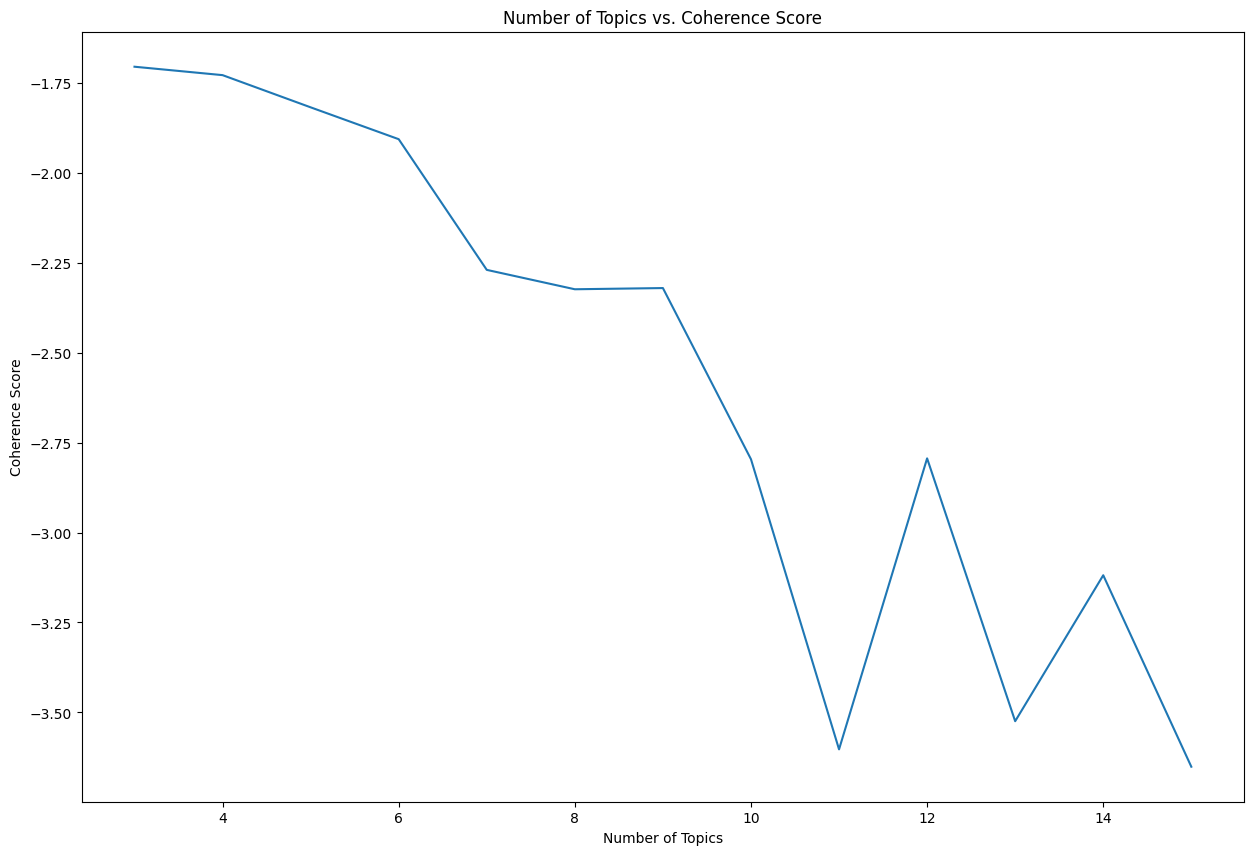

In [30]:
# higher is better

plt.figure(figsize=(15, 10))
plt.plot(range(3, 16), coherences)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Number of Topics vs. Coherence Score")

Text(0.5, 1.0, 'Number of Topics vs. Log Perplexity')

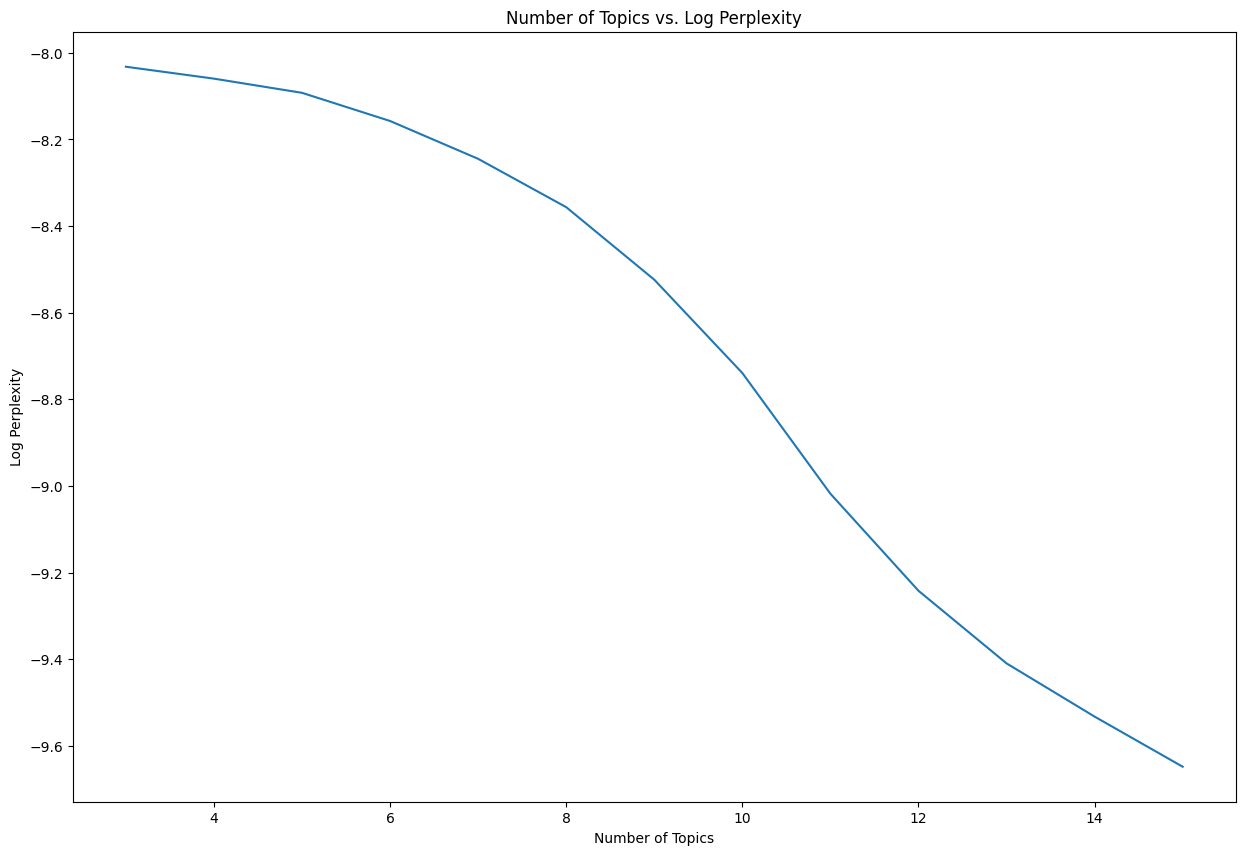

In [31]:
# lower is better

plt.figure(figsize=(15, 10))
plt.plot(range(3, 16), perplexities)
plt.xlabel("Number of Topics")
plt.ylabel("Log Perplexity")
plt.title("Number of Topics vs. Log Perplexity")

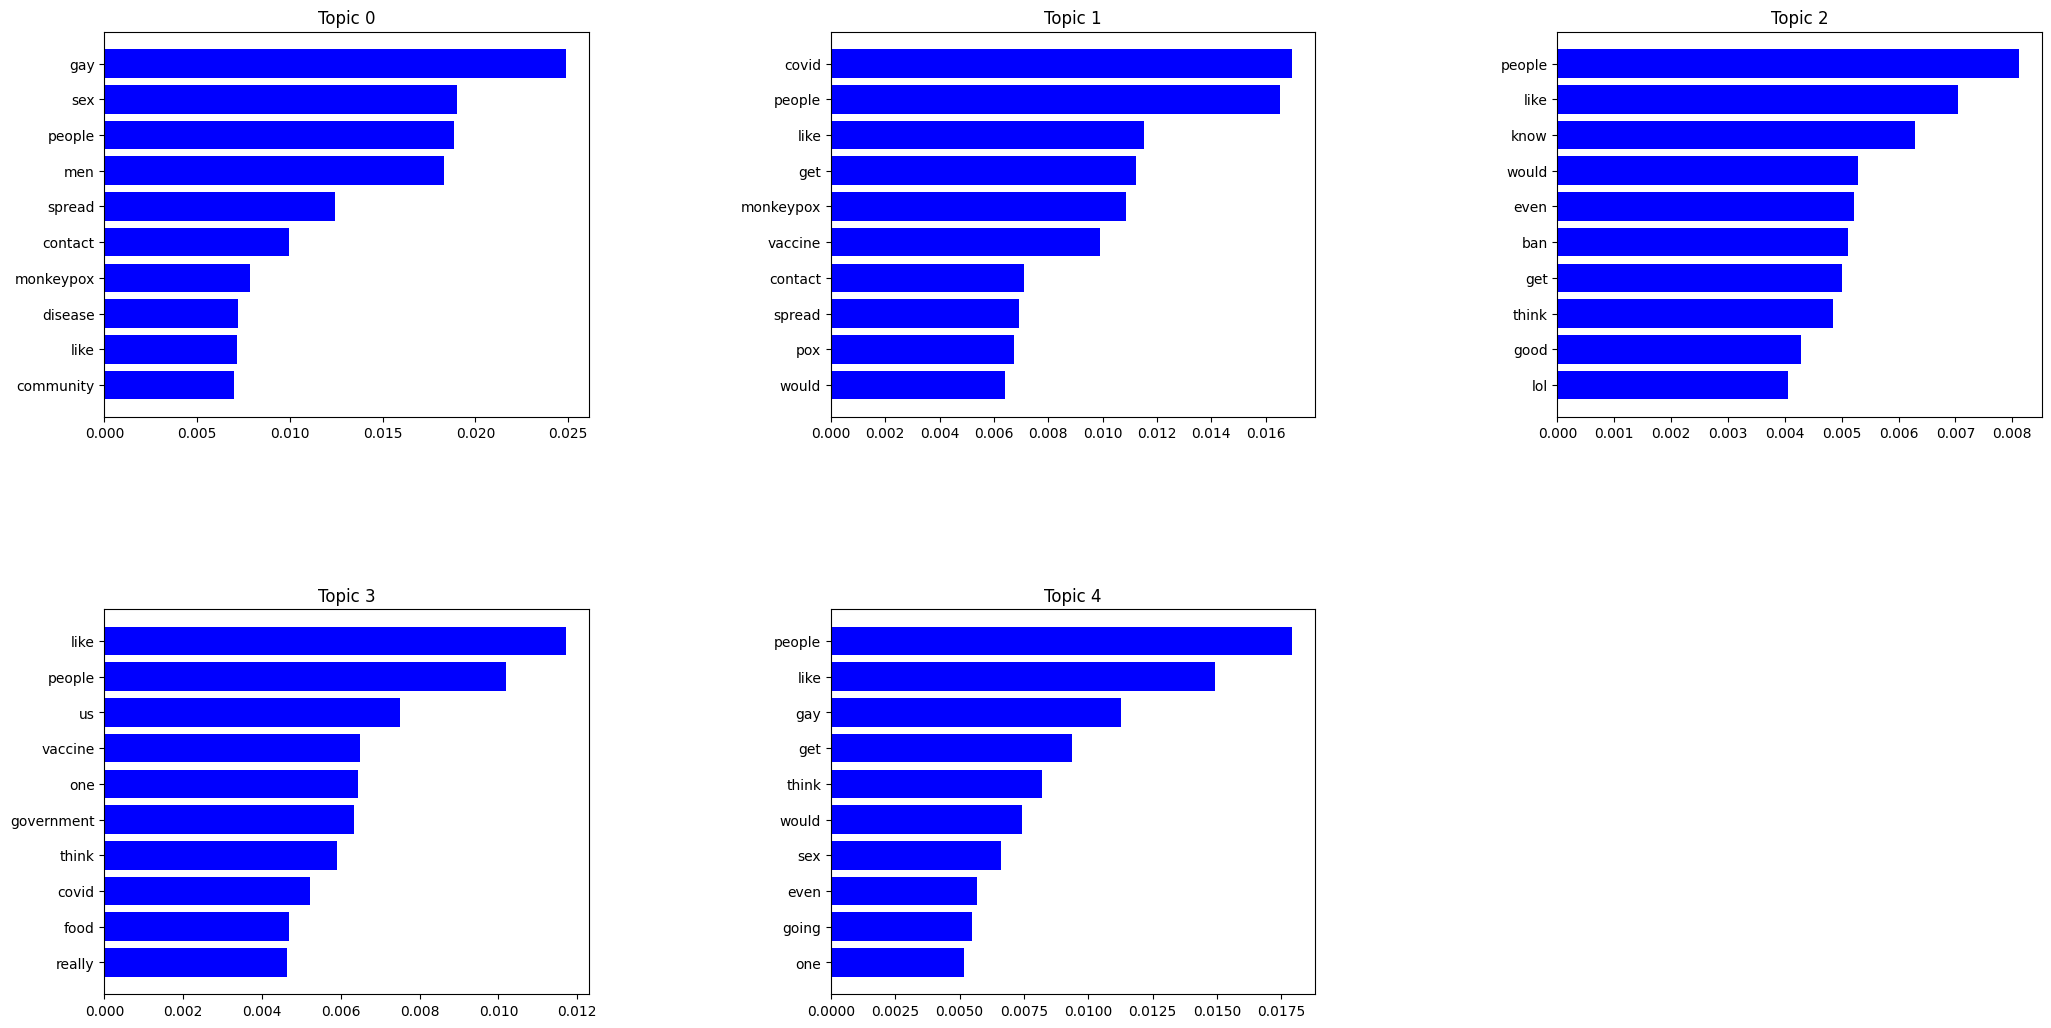

In [34]:
NUM_TOPICS = 5
lda_model = LdaModel(
        corpus=corpus,
        num_topics=NUM_TOPICS,
        id2word=dictionary,
        random_state=random_state + 6 # 2
)

def plot_top_words(lda=lda_model, nb_topics=NUM_TOPICS, nb_words=10):
    top_words = [[word for word, _ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _, beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(NUM_TOPICS)) + 1, round(math.sqrt(NUM_TOPICS)) + 1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(25, 20))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center', color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic " + str(i))
        
plot_top_words(lda=lda_model)

In [35]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
vis

/Users/conneryurkon/miniconda3/envs/cs8803dsn/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/Users/conneryurkon/miniconda3/envs/cs8803dsn/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/conneryurkon/miniconda3/envs/cs8803dsn/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/conneryurkon/miniconda3/envs/cs8803dsn/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the im

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.129099  0.021424       1        1  27.446064
1     -0.030081 -0.053917       2        1  26.114277
4     -0.037932  0.011655       3        1  17.833662
3      0.101113 -0.081032       4        1  15.604145
2      0.096000  0.101870       5        1  13.001851, topic_info=         Term         Freq        Total Category  logprob  loglift
171       gay  5973.000000  5973.000000  Default  30.0000  30.0000
174       men  3984.000000  3984.000000  Default  29.0000  29.0000
319       sex  4691.000000  4691.000000  Default  28.0000  28.0000
89      covid  4253.000000  4253.000000  Default  27.0000  27.0000
1069  contact  3187.000000  3187.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
9         one   256.374832  3155.005483   Topic5  -5.7857  -0.4700
67       also   252.436388  2922.921071   Topic5  -5.8012  -0.4091
61       well   237.897964  1654.062196   Topic5  -5.8605   0.1009
182      shit   226.590317  1369.325739   Topic5  -5.9092   0.2411
354      make   226.699920  1431.749206   Topic5  -5.9087   0.1971

[463 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
9719      1  0.019635  accident
9719      2  0.039270  accident
9719      3  0.922836  accident
513       1  0.897299  activity
513       2  0.036133  activity
...     ...       ...       ...
466       3  0.058813     years
466       4  0.333544     years
466       5  0.086206     years
1656      1  0.075672    zombie
1656      4  0.908069    zombie

[1224 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 4, 3])

In [36]:
lda_model.print_topics()

[(0,
  '0.025*"gay" + 0.019*"sex" + 0.019*"people" + 0.018*"men" + 0.012*"spread" + 0.010*"contact" + 0.008*"monkeypox" + 0.007*"disease" + 0.007*"like" + 0.007*"community"'),
 (1,
  '0.017*"covid" + 0.017*"people" + 0.012*"like" + 0.011*"get" + 0.011*"monkeypox" + 0.010*"vaccine" + 0.007*"contact" + 0.007*"spread" + 0.007*"pox" + 0.006*"would"'),
 (2,
  '0.008*"people" + 0.007*"like" + 0.006*"know" + 0.005*"would" + 0.005*"even" + 0.005*"ban" + 0.005*"get" + 0.005*"think" + 0.004*"good" + 0.004*"lol"'),
 (3,
  '0.012*"like" + 0.010*"people" + 0.008*"us" + 0.006*"vaccine" + 0.006*"one" + 0.006*"government" + 0.006*"think" + 0.005*"covid" + 0.005*"food" + 0.005*"really"'),
 (4,
  '0.018*"people" + 0.015*"like" + 0.011*"gay" + 0.009*"get" + 0.008*"think" + 0.007*"would" + 0.007*"sex" + 0.006*"even" + 0.005*"going" + 0.005*"one"')]

In [37]:
def get_topic_assignment(idx):
    return max(lda_model[corpus[idx]], key=lambda x: x[1])[0]

In [46]:
df['topic'] = [get_topic_assignment(idx) for idx in range(len(df.index))]

In [47]:
df.head()

,ag,ci,se,C1,C2,C3,A1,A2,A3,ID,Link,C1_link,C2_link,C3_link,C1_LIWC,C2_LIWC,C3_LIWC,Whole_Discussion_LIWC,topic
ind,,,,,,,,,,,,,,,,,,,
0,0,0,0,>anti-punctuationwhy should i care about punct...,Ah… I get it now. You’re still too young… have...,i have two PhDs dumb ass,killer0214,DedsecEric,killer0214,wtjgdk,0,NaN,NaN,NaN,"[('function (Function Words)', 13), ('verb (Ve...","[('function (Function Words)', 7), ('relativ (...","[('function (Function Words)', 2), ('informal ...","[('function (Function Words)', 22), ('verb (Ve...",1
1,1,0,1,Ah… I get it now. You’re still too young… have...,i have two PhDs dumb ass,One in Anti-punctuation; the other in Palindro...,DedsecEric,killer0214,DedsecEric,wtjgdk,0,NaN,NaN,NaN,"[('function (Function Words)', 7), ('relativ (...","[('function (Function Words)', 2), ('informal ...","[('function (Function Words)', 5), ('prep (Pre...","[('function (Function Words)', 14), ('relativ ...",4
2,1,0,0,i have two PhDs dumb ass,One in Anti-punctuation; the other in Palindro...,no biology and chemistry,killer0214,DedsecEric,killer0214,wtjgdk,0,NaN,NaN,NaN,"[('function (Function Words)', 2), ('informal ...","[('function (Function Words)', 5), ('prep (Pre...","[('function (Function Words)', 2), ('negate (N...","[('function (Function Words)', 9), ('pronoun (...",4
3,0,0,0,One in Anti-punctuation; the other in Palindro...,no biology and chemistry,"Apparently, no English either.",DedsecEric,killer0214,DedsecEric,wtjgdk,0,NaN,NaN,NaN,"[('function (Function Words)', 5), ('prep (Pre...","[('function (Function Words)', 2), ('negate (N...","[('function (Function Words)', 1), ('negate (N...","[('function (Function Words)', 8), ('prep (Pre...",4
4,0,0,0,no biology and chemistry,"Apparently, no English either.",im working on one in psychology and English,killer0214,DedsecEric,killer0214,wtjgdk,0,NaN,NaN,NaN,"[('function (Function Words)', 2), ('negate (N...","[('function (Function Words)', 1), ('negate (N...","[('function (Function Words)', 4), ('verb (Ver...","[('function (Function Words)', 7), ('work (Wor...",4


In [48]:
df['topic'].value_counts()

1    3295
0    2940
4    2365
3    2092
2    1898
Name: topic, dtype: int64

In [43]:
df.drop(columns=['agg'], inplace=True)

In [44]:
df.to_excel('../lda/v3/topic_assignments.xlsx')